In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Telco_Customer_Churn_Dataset  (1).csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.shape

(7043, 21)

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [9]:
df.drop('customerID', axis=1, inplace=True)

In [10]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

In [11]:
multi_cat_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [12]:
df.shape, df.columns.tolist()

((7043, 31),
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'PaperlessBilling',
  'MonthlyCharges',
  'TotalCharges',
  'Churn',
  'MultipleLines_No phone service',
  'MultipleLines_Yes',
  'InternetService_Fiber optic',
  'InternetService_No',
  'OnlineSecurity_No internet service',
  'OnlineSecurity_Yes',
  'OnlineBackup_No internet service',
  'OnlineBackup_Yes',
  'DeviceProtection_No internet service',
  'DeviceProtection_Yes',
  'TechSupport_No internet service',
  'TechSupport_Yes',
  'StreamingTV_No internet service',
  'StreamingTV_Yes',
  'StreamingMovies_No internet service',
  'StreamingMovies_Yes',
  'Contract_One year',
  'Contract_Two year',
  'PaymentMethod_Credit card (automatic)',
  'PaymentMethod_Electronic check',
  'PaymentMethod_Mailed check'])

In [13]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 30), (1409, 30), (5634,), (1409,))

In [15]:
# Optimize scaling to apply only to numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

In [16]:
selector = SelectKBest(mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [17]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

In [18]:
# Compute class weights for CatBoost
catboost_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)

param_grids = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(class_weight='balanced', random_state=42),
        'params': {'max_depth': [4, 6, 8, None], 'min_samples_split': [2, 5]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {'n_estimators': [100, 200], 'max_depth': [6, 10]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_iter_no_change': [5], 'validation_fraction': [0.1]}
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=(y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]),
            random_state=42
        ),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostClassifier(verbose=0, random_state=42, class_weights=catboost_class_weights),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    }
}

In [19]:
best_models = {}
results = {}

for name, mp in param_grids.items():
    grid = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_balanced, y_train_balanced)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_selected)
    y_proba = best_model.predict_proba(X_test_selected)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'mse': mean_squared_error(y_test, y_pred)
    }
    best_models[name] = best_model

for model_name, metrics in results.items():
    print(f"\n{model_name} results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



LogisticRegression results:
accuracy: 0.7317
precision: 0.4966
recall: 0.7807
f1_score: 0.6071
roc_auc: 0.8229
mse: 0.2683

DecisionTree results:
accuracy: 0.7268
precision: 0.4904
recall: 0.7487
f1_score: 0.5926
roc_auc: 0.7948
mse: 0.2732

RandomForest results:
accuracy: 0.7452
precision: 0.5139
recall: 0.7433
f1_score: 0.6077
roc_auc: 0.8245
mse: 0.2548

GradientBoosting results:
accuracy: 0.7424
precision: 0.5097
recall: 0.7727
f1_score: 0.6142
roc_auc: 0.8259
mse: 0.2576

XGBoost results:
accuracy: 0.7381
precision: 0.5046
recall: 0.7353
f1_score: 0.5985
roc_auc: 0.8128
mse: 0.2619

CatBoost results:
accuracy: 0.7523
precision: 0.5239
recall: 0.7326
f1_score: 0.6109
roc_auc: 0.8214
mse: 0.2477


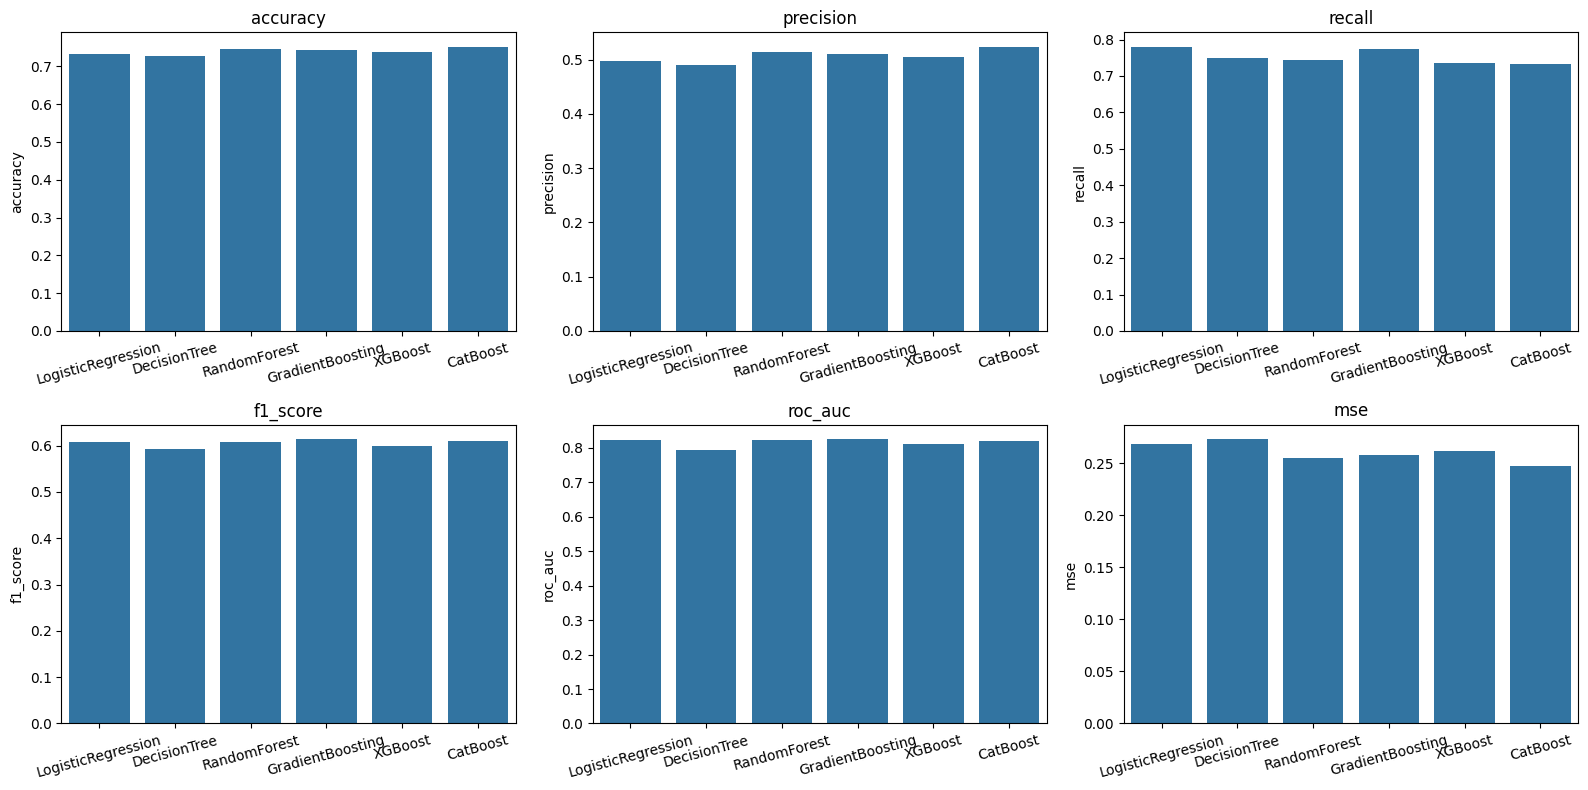

In [20]:
# Adjust plotting logic to handle missing metrics
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'mse']

plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    values = [results[m].get(metric, None) for m in model_names]  # Use .get() to avoid KeyError
    if None in values:
        print(f"Warning: Metric '{metric}' is missing for some models.")
        values = [v for v in values if v is not None]  # Filter out None values
    sns.barplot(x=model_names[:len(values)], y=values)  # Adjust x-axis labels
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

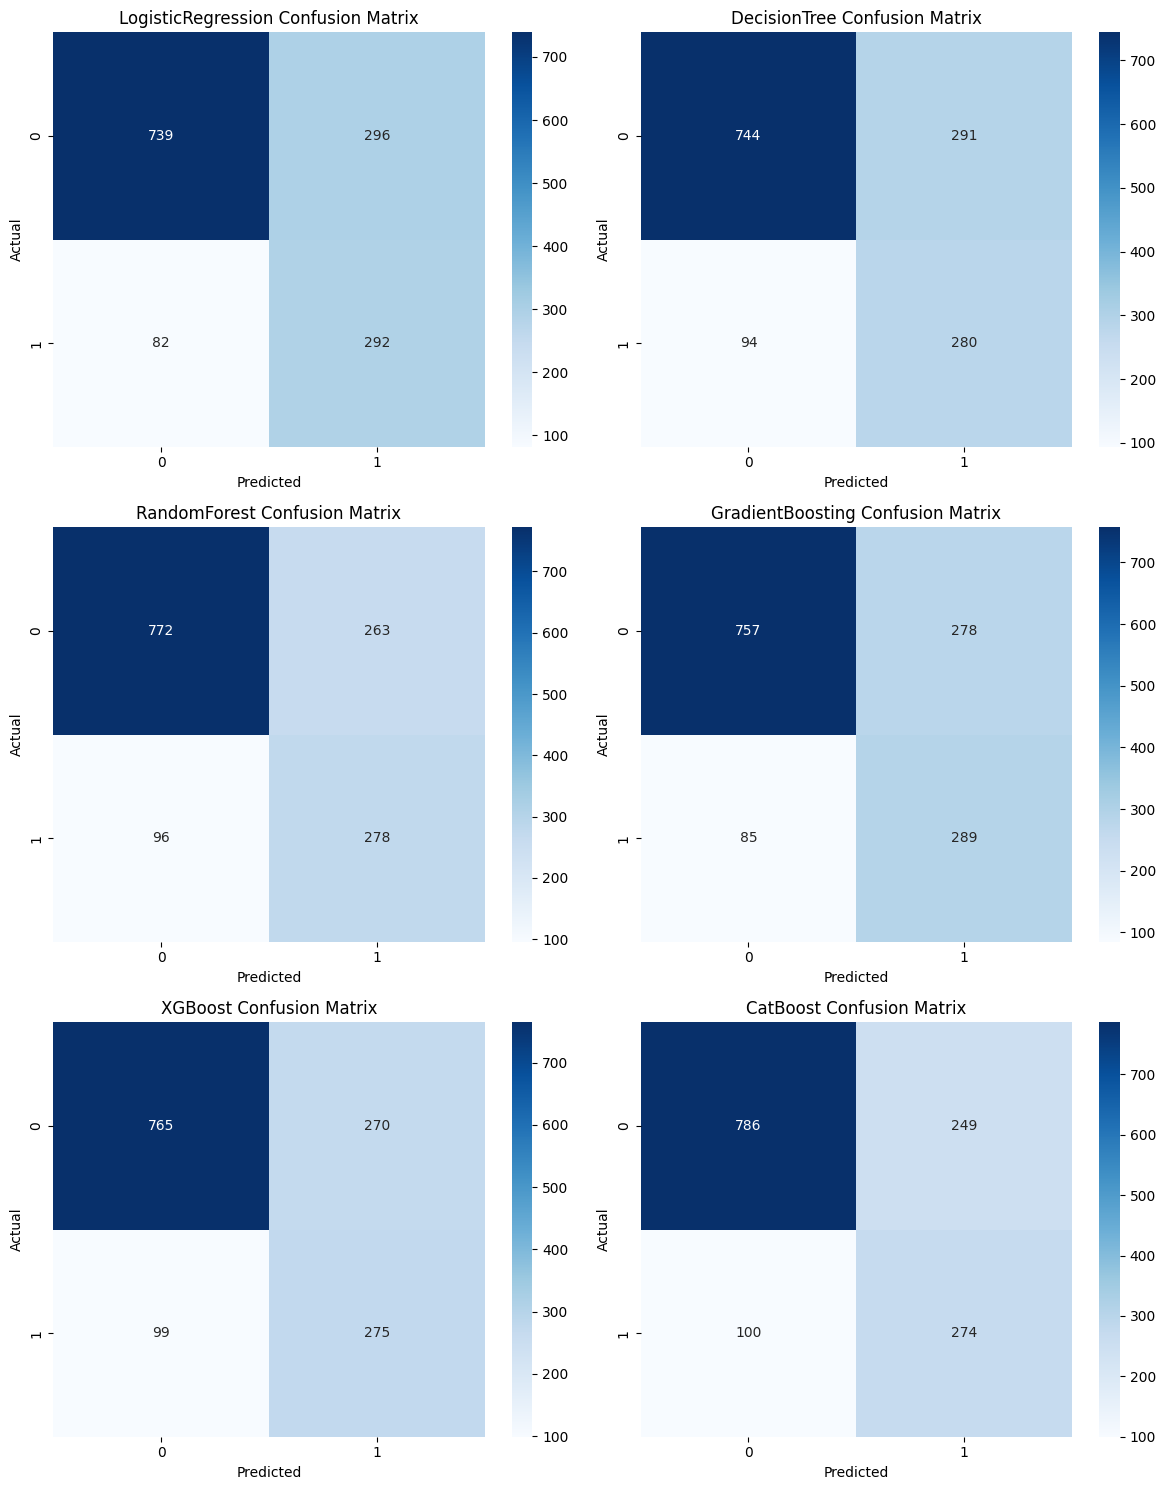

In [21]:
import math
# Confusion matrices for each model
total_models = len(best_models)
cols = 2
rows = math.ceil(total_models / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()
for idx, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

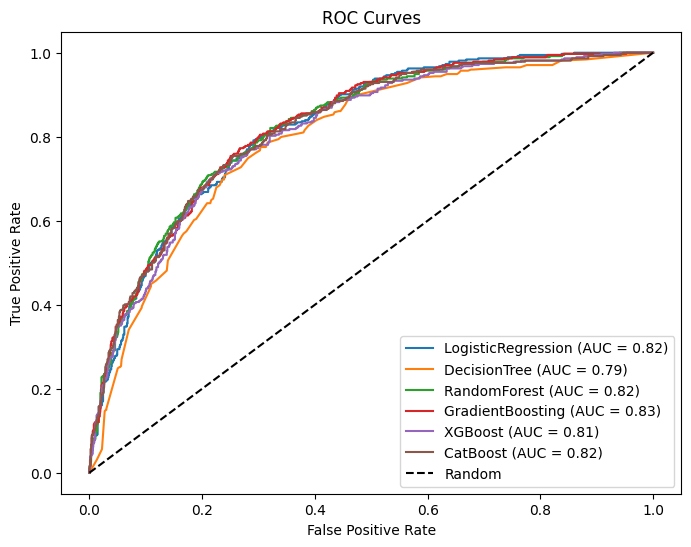

In [22]:
# ROC curves for each model
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Selecting the Most Optimal Model Using All Metrics

To ensure the best model is chosen based on a holistic view, we combine all key metrics (accuracy, precision, recall, F1-score, ROC-AUC, and MSE) into a composite score. Each metric is normalized, MSE is inverted, and all are averaged to select the most optimal model.

Selected most optimal model: CatBoost

Performance metrics for the selected model:
accuracy: 0.7523
precision: 0.5239
recall: 0.7326
f1_score: 0.6109
roc_auc: 0.8214
mse: 0.2477

Classification Report:
              precision    recall  f1-score   support

           0     0.8871    0.7594    0.8183      1035
           1     0.5239    0.7326    0.6109       374

    accuracy                         0.7523      1409
   macro avg     0.7055    0.7460    0.7146      1409
weighted avg     0.7907    0.7523    0.7633      1409



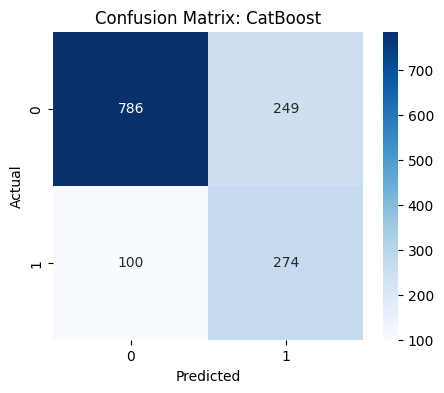

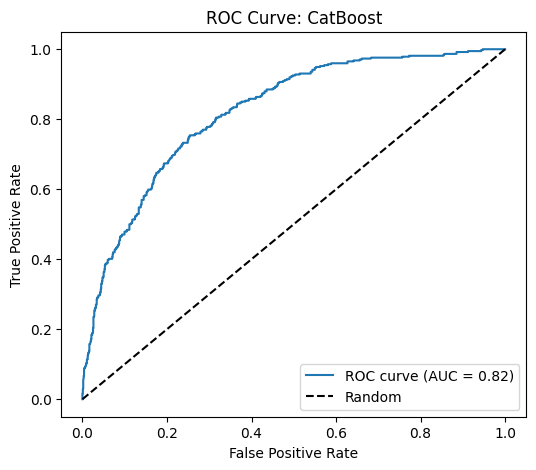

In [23]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Prepare metrics for normalization
metric_names = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
reverse_metric = ['mse']  # Lower is better for MSE

# Collect metric values for all models
metric_matrix = np.array([[results[m][metric] for metric in metric_names + reverse_metric] for m in results])

# Normalize metrics (0-1 scale)
scaler = MinMaxScaler()
metric_matrix_norm = scaler.fit_transform(metric_matrix)

# Invert MSE (last column) so higher is better
metric_matrix_norm[:, -1] = 1 - metric_matrix_norm[:, -1]

# Compute composite score (average of all normalized metrics)
composite_scores = metric_matrix_norm.mean(axis=1)

# Find the best model index
best_idx = np.argmax(composite_scores)
best_model_name = list(results.keys())[best_idx]
best_model = best_models[best_model_name]

print(f"Selected most optimal model: {best_model_name}")
print("\nPerformance metrics for the selected model:")
for metric, value in results[best_model_name].items():
    print(f"{metric}: {value:.4f}")

# Classification report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_pred_best = best_model.predict(X_test_selected)
y_proba_best = best_model.predict_proba(X_test_selected)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, digits=4))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {best_model_name}')
plt.legend()
plt.show()

In [24]:
import joblib
joblib.dump(best_model, "best_model.pkl")
print(f"Saved {best_model_name} as best_model.pkl")

Saved CatBoost as best_model.pkl


In [25]:
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector, "selector.pkl")
print("Exported scaler.pkl and selector.pkl")

Exported scaler.pkl and selector.pkl
